In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from matplotlib.pyplot import plot

In [2]:
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
features = np.loadtxt("../Data/Training_data/big_test_features.txt")
labels = np.loadtxt("../Data/Training_data/big_test_labels.txt")

In [55]:
# Split label array into individual columns
true_labels = labels[:, 0]          # Just the actual label
avg_radius_column = labels[:, 1]    # The one you want to move to features

# Reshape so you can concatenate it
avg_radius_column = avg_radius_column.reshape(-1, 1)

# Concatenate to features
features_total_np = np.hstack([features, avg_radius_column])

# Overwrite labels array with only the true label
labels_total_np = true_labels.reshape(-1, 1)


features_total_np = np.delete(features_total_np, [1,4,5,9,11], axis=1) # Remove variation


In [56]:
features_total_np.shape

(2297105, 7)

In [57]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features_total_np, labels_total_np, test_size=0.2, random_state=42)



# Standardize input features (only fit on training data!)
scaler = StandardScaler()


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_grid, _, y_grid, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42) # Only using 40% of the data for gridsearching



In [58]:
X_test.shape

(459421, 7)

In [59]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=550, max_depth = 10, learning_rate=0.01)
xgb.fit(X_train, y_train)
print('Train R2 score: ', xgb.score(X_train, y_train))
print('Test R2 score: ', xgb.score(X_test, y_test))




Train R2 score:  0.7660881544354627
Test R2 score:  0.7550623489407782


In [60]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

y_pred = xgb.predict(X_test)


# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")
    
    
print_regression_metrics(y_test, y_pred)


📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.7551
Mean Absolute Error (MAE): 0.6875
Mean Squared Error (MSE): 0.8598
Root Mean Squared Error (RMSE): 0.9273
Max Error        : 9.9664


# -----------------------

In [9]:
param_grid = {
    "n_estimators": [450, 500, 550],           # number of trees
    "max_depth": [9, 10, 11, 12],                # depth of each tree
    "learning_rate": [0.01, 0.001],        # step size shrinkage
    "subsample": [0.2, 0.4, 0.6],              # % of data per tree
}


In [10]:
search = GridSearchCV(
    XGBRegressor(),
    param_grid=param_grid,
    scoring="r2",
    cv=3,
    verbose=2
)


In [11]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.2; total time=  31.5s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.2; total time=  31.1s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.2; total time=  29.3s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.4; total time=  30.1s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.4; total time=  30.5s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.4; total time=  28.5s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.6; total time=  28.0s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.6; total time=  28.5s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=450, subsample=0.6; total time=  28.6s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=500, subsample=0.2; total time=  30.9s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=500, 

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.001],
                         'max_depth': [9, 10, 11, 12],
                         'n_estimators': [450, 500, 550],
                         'subsample': [0.2, 0.4, 0.6]},
             scoring='r2', verbose=2)

In [13]:
print(f'Best hyperparameters: {search.best_params_}')
print(f'Train R2 score: {search.score(X_train, y_train)}')
print(f'Test R2 score: {search.score(X_test, y_test)}')

from joblib import dump, load

estimator = search.best_estimator_
dump(estimator, "./gridsearch_2.joblib")

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 550, 'subsample': 0.4}
Train R2 score: 0.8076809041410049
Test R2 score: 0.7988966051050641


['./gridsearch_2.joblib']

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

y_pred = estimator.predict(X_test)


# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")
    
    
print_regression_metrics(y_test, y_pred)

📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.7989
Mean Absolute Error (MAE): 0.6323
Mean Squared Error (MSE): 0.7059
Root Mean Squared Error (RMSE): 0.8402
Max Error        : 9.8199


<Figure size 1000x600 with 0 Axes>

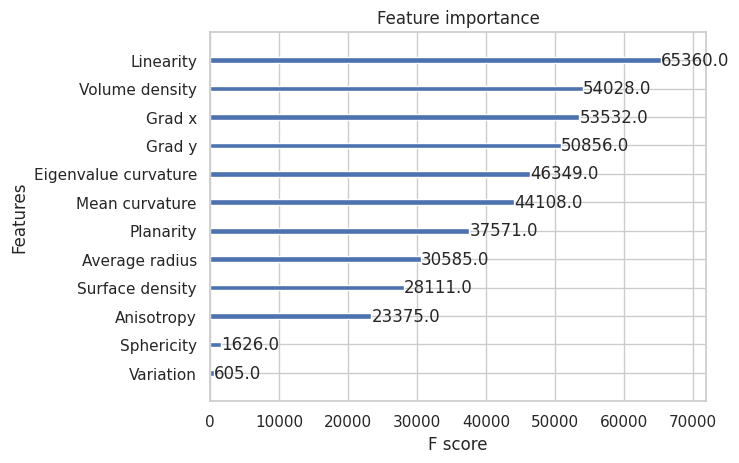

In [42]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

feature_names = [
    "Eigenvalue curvature", "Anisotropy", "Linearity", "Planarity", "Sphericity", 
    "Variation", "Grad x", "Grad y", "Mean curvature", "Surface density", "Volume density", "Average radius"
]

estimator.get_booster().feature_names = feature_names
plt.figure(figsize=(10, 6))

plot_importance(estimator)

plt.savefig("F1_scores_xgboost2.png", dpi=1000)
plt.show()

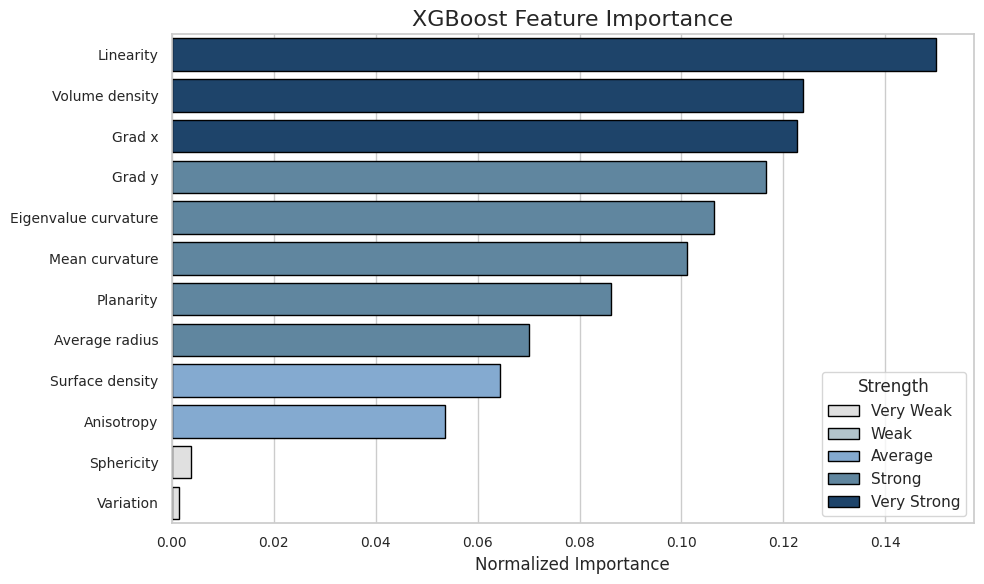

In [38]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
booster = estimator.get_booster()
importance = booster.get_score(importance_type='weight')

# Create DataFrame
df = pd.DataFrame(list(importance.items()), columns=["Feature", "F_Score"])
df["F_Score"] = df["F_Score"] / df["F_Score"].sum()  # Normalize
df = df.sort_values("F_Score", ascending=False)

# Categorize by importance strength
bins = [0, 0.01, 0.03, 0.07, 0.12, 1.0]
labels = ["Very Weak", "Weak", "Average", "Strong", "Very Strong"]
df["Strength"] = pd.cut(df["F_Score"], bins=bins, labels=labels)

# Color palette
palette = {
    "Very Weak": "#e0e0e0",
    "Weak": "#aec6cf",
    "Average": "#77aadd",
    "Strong": "#5588aa",
    "Very Strong": "#114477"
}

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x="F_Score",
    y="Feature",
    data=df,
    hue="Strength",
    dodge=False,
    palette=palette,
    edgecolor="black"
)

# Customize
plt.title("XGBoost Feature Importance", fontsize=16)
plt.xlabel("Normalized Importance", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Strength", loc="lower right", frameon=True)
plt.tight_layout()

plt.savefig('./Feature_importance_xgboost2.png', dpi=2000)
plt.show()

In [21]:
from joblib import load

model_1 = load(filename="./XGBRegressor models/gridsearch_1.joblib")


pred1 = model_1.predict(X_test)


print_regression_metrics(y_test, pred1)


📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.7988
Mean Absolute Error (MAE): 0.6320
Mean Squared Error (MSE): 0.7061
Root Mean Squared Error (RMSE): 0.8403
Max Error        : 9.5049
